We want to test whether the data we get are from a normal distribution.
Basic outline:
1. Get data (scalars).
2. Estimate $\mu$ and $\sigma$ using moment conditions under the null. Use $\Omega$ that we can find from assuming normality.
3. Calculate $J_N$.
4. Test whether $J_N$ is really distributed as chi sq with $k-2$ degrees of freedom.

From Ethan:
Implement the test you've devised using =python=. You may want
to use =scipy.stats.distributions.chi2.cdf= and =scipy.optimize.minimize=.

In [15]:
import numpy as np
from scipy.stats import distributions as iid
from scipy.stats import logistic as logist
from scipy.optimize import minimize
from matplotlib import pyplot as plt

In [5]:
def doublefact(n):
     if n <= 0:
         return 1
     else:
         return n * doublefact(n-2)

In [6]:
"""mu, sigma are proposed pop mean and std dev. k is number of moments"""
def weight_mat(sigma, k):
    Omega = np.zeros((k,k))
    for i in range(k):
        for j in range(k):
            # redefine i,j to start at 1
            i1 = i + 1
            j1 = j + 1
            # define constant for when both are even
            constant = doublefact(i1+j1-1)-doublefact(i1-1)*doublefact(j1-1)
            if i1 % 2 == 0: # i is even
                if j1 % 2 == 0: # j is also even
                    Omega[i,j] = (sigma**(i1+j1))*constant
            if i1 % 2 == 1: # i is odd
                if j1 % 2 == 1: # j is also odd
                    Omega[i,j] = (sigma**(i1+j1))*doublefact(i1+j1-1)
    return np.linalg.inv(Omega)

In [7]:
def g_vec(sigma, mu, x, k):
    gvect = np.zeros(k)
    for i in range(k):
        if i % 2 == 0: # if i is even
            gvect[i] = (x-mu)**(i+1)
        if i % 2 == 1: # if i is odd
            gvect[i] = (x-mu)**(i+1) - doublefact(i)*sigma**(i+1)
    return gvect

In [8]:
def g_N(sigma, mu, X, k):
    N = X.shape[0]
    g_N = np.zeros(k)
    for x in X:
        g_N = g_N + g_vec(sigma, mu, x, k)*(1/N)
    return g_N

In [9]:
def objective_funct(param, *args):
    sigma = param[0]
    mu = param[1]
    X = args[0]
    k = args[1]
    N = X.shape[0]
    gN = g_N(sigma, mu, X, k)
    A = weight_mat(sigma, k)
    return N*(gN.T @ A @ gN)

In [10]:
def normaldist_gmm(X,k):
    """X is data. k is number of moment restrictions.
        Returns array where first value is estimated sigma, second is estimated mu."""
    x_init = np.asarray([1,0]) # start with guess sigma=1, mu=0
    bN = minimize(fun=objective_funct, x0=x_init, args=(X,k)).x
    return bN

In [20]:
def pvalue(X, k):
    bN = normaldist_gmm(X,k)
    JN = objective_funct(bN, X,k)
    return (1 - iid.chi2.cdf(x=JN, df=(k-2)))

Now generate some data to run our test on. Hopefully it will not reject the data from the normal distribution, but it will reject the data from the logistic distribution, which looks similar to me.

In [26]:
# X is normally distributed with mean=1,sd=2.
X = iid.norm.rvs(loc=1, scale=2, size=1000)
# Y has a logistic distribution
Y = logist.rvs(size=1000)

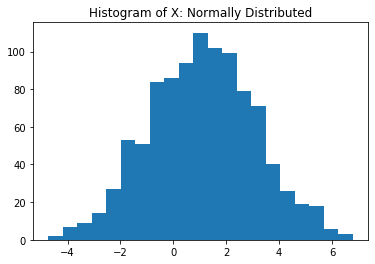

In [27]:
_ = plt.hist(X, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of X: Normally Distributed")
plt.show()

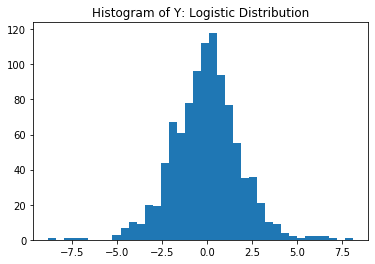

In [28]:
_ = plt.hist(Y, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of Y: Logistic Distribution")
plt.show()

Now we're ready to use this on our data that we generated.

In [31]:
print(pvalue(X, 3))
print(pvalue(X, 4))
print(pvalue(X, 5))
print(pvalue(X, 6))
print(pvalue(X, 7))
print(pvalue(X, 8))

0.7361482909828037
0.28574106010518174
0.4693167424239404
0.6386762799268081
0.7661839417619782
0.8081284521455068


Good. We never reject.

In [32]:
print(pvalue(Y, 3))
print(pvalue(Y, 4))
print(pvalue(Y, 5))
print(pvalue(Y, 6))
print(pvalue(Y, 7))
print(pvalue(Y, 8))

0.9168723808006406
0.0
1.1102230246251565e-16
2.220446049250313e-16
1.1102230246251565e-16
4.440892098500626e-16


Once we get to k=4, our test is never fooled by the data from the logistic distribution.

Optimal k? I have no idea. How about 1000? I see no reason why more is not more in this case. I'm almost certainly missing something.

In [ ]:
"""OLD"""
def omega_est(X,k):
    N = X.shape[0] # sample size
    xbar = np.mean(X) # sample mean
    ssr = 0
    for x in X:
        ssr = ssr + (x - xbar)**2
    s2 = (1/(N-1))*ssr # sample variance
    # by setting Omega to zero, we only need to change for ->
    # i,j are both even or both odd
    Omega = np.zeros((k,k))
    for i in range(k):
        for j in range(k):
            # define constant for when both are even
            constant = doublefact(i+j-1)-doublefact(i-1)*doublefact(j-1)
            if i % 2 == 0: # i is even
                if j % 2 == 0: # j is also even
                    Omega[i,j] = s2**((i+j)/2)*constant
            if i % 2 == 1: # i is odd
                if j % 2 == 1: # j is also odd
                    Omega[i,j] = s2**((i+j)/2)*doublefact(i+j-1)
    return Omega